# **Model 1** - Random Forest, TF-IDF method without numeric features

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Load the data

train_data_path = '/content/train.csv'
test_data_path = '/content/test.csv'

train_data = pd.read_csv(train_data_path)

test_data = pd.read_csv(test_data_path)
test_data = test_data.dropna(subset=['label'])
# test_data = test_data[test_data['id'].apply(lambda x: isinstance(x, float))]


# Combine 'title' and 'text' into a single feature for train and test data
train_data['content'] = train_data['author'].fillna('') +  train_data['title'].fillna('') + ' ' + train_data['text'].fillna('')
test_data['content'] = test_data['author'].fillna('') + test_data['title'].fillna('') + ' ' + test_data['text'].fillna('')

# Define features and target for the training data
X_train = train_data['content']
y_train = train_data['label']

# Define features for the test data
X_test = test_data['content']

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train a Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_tfidf, y_train)

# Predict the labels for the test set
y_test_pred = model.predict(X_test_tfidf)

y_test = test_data['label']  # Assuming 'label' column exists in test data for evaluation

# Print the classification report and accuracy score
print(classification_report(y_test, y_test_pred))
print("Accuracy:", accuracy_score(y_test, y_test_pred))

<ipython-input-7-48fe653a5ea0>:13: DtypeWarning: Columns (20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,27

              precision    recall  f1-score   support

         0.0       0.59      0.66      0.63      2323
         1.0       0.70      0.63      0.66      2861

    accuracy                           0.64      5184
   macro avg       0.64      0.65      0.64      5184
weighted avg       0.65      0.64      0.65      5184

Accuracy: 0.6440972222222222


In [ ]:
!pip install --upgrade pip
!pip install torch==1.10.0
!pip install transformers==4.18.0
!pip install tqdm

ERROR: Could not find a version that satisfies the requirement torch==1.10.0 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1)
ERROR: No matching distribution found for torch==1.10.0


# **Model 2**- Bert method without numeric features

In [ ]:
import pandas as pd
from transformers import DistilBertTokenizer, DistilBertModel, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
import numpy as np

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = self.texts[item]
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = NewsDataset(
        texts=df.content.to_numpy(),
        labels=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4,
        collate_fn=lambda x: {
            'input_ids': torch.stack([i['input_ids'] for i in x]),
            'attention_mask': torch.stack([i['attention_mask'] for i in x]),
            'label': torch.stack([i['label'] for i in x]),
            'text': [i['text'] for i in x]
        }
    )

class NewsClassifier(nn.Module):
    def __init__(self, n_classes):
        super(NewsClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs[0][:, 0, :]
        output = self.drop(pooled_output)
        return self.out(output)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["label"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["label"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

def get_predictions(model, data_loader, device):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts.extend(d["text"])
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["label"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            texts.extend(d["text"])
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, real_values

# Load the data
train_data_path = '/content/train.csv'
test_data_path = '/content/test.csv'

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)
test_data = test_data.dropna(subset=['label'])

# Combine 'title' and 'text' into a single feature for train and test data
train_data['content'] = train_data['author'].fillna('') +  train_data['title'].fillna('') + ' ' + train_data['text'].fillna('')
test_data['content'] = test_data['author'].fillna('') + test_data['title'].fillna('') + ' ' + test_data['text'].fillna('')


# Define features and target for the training data
X_train = train_data['content']
y_train = train_data['label']

# Define features and target for the test data
X_test = test_data['content']
y_test = test_data['label']

# Set up BERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_len = 160
batch_size = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_data_loader = create_data_loader(train_data, tokenizer, max_len, batch_size)
test_data_loader = create_data_loader(test_data, tokenizer, max_len, batch_size)

model = NewsClassifier(n_classes=2)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * 1
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

# Train the model
print('Training the model...')
history = {'train_acc': [], 'train_loss': []}
train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(train_data)
)

print(f'Train loss {train_loss} accuracy {train_acc}')
history['train_acc'].append(train_acc)
history['train_loss'].append(train_loss)

# Evaluate the model
print('Evaluating the model...')
test_acc, test_loss = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(test_data)
)

print(f'Test Accuracy: {test_acc}')
print(f'Test Loss: {test_loss}')

# Get predictions
texts, predictions, real_values = get_predictions(model, test_data_loader, device)
print(classification_report(real_values, predictions))
print(f"Accuracy: {accuracy_score(real_values, predictions)}")


<ipython-input-1-6462f2def5f4>:164: DtypeWarning: Columns (20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,2

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training the model...


100%|██████████| 2600/2600 [4:54:51<00:00,  6.80s/it]

Train loss 0.017330144330405275 accuracy 0.9928365384615384
Evaluating the model...


Test Accuracy: 0.6359953703703703
Test Loss: 3.4414271842918445
              precision    recall  f1-score   support

           0       0.58      0.65      0.62      2323
           1       0.69      0.62      0.65      2861

    accuracy                           0.64      5184
   macro avg       0.64      0.64      0.64      5184
weighted avg       0.64      0.64      0.64      5184

Accuracy: 0.6359953703703703


# **Model 3** - Random Forest, TF-IDF method with numeric features

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from scipy.sparse import hstack

# Paths to the feature-engineered datasets
train_data_path = '/content/TrainSet_FeatureEngeneering.csv'
test_data_path = '/content/TestSet_FeatureEngeneering.csv'

# Load the data
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

# Remove rows where 'id' is string or NULL
test_data = test_data[pd.to_numeric(test_data['id'], errors='coerce').notnull()]

# Combine 'title' and 'text_no_stopwords' into a single feature for train and test data
train_data['content'] = train_data['title'].fillna('') + ' ' + train_data['text_no_stopwords'].fillna('')
test_data['content'] = test_data['title'].fillna('') + ' ' + test_data['text_no_stopwords'].fillna('')

# Ensure labels are integers and handle missing values
train_data['label'] = train_data['label'].fillna(-1).astype(int)
test_data['label'] = test_data['label'].fillna(-1).astype(int)

# Define features and target for the training data
X_train_text = train_data['content']
y_train = train_data['label']
X_test_text = test_data['content']
y_test = test_data['label']

# Numeric features to include
numeric_features = ['text_word_count', 'title_word_count', 'text_unique_word_count', 'title_unique_word_count',
                    'text_punctuation_count', 'title_punctuation_count', 'text_sentiment', 'named_entity_count',
                    'exclamation_count', 'question_count', 'capital_ratio']

# Ensure numeric features are float type
train_data[numeric_features] = train_data[numeric_features].astype(float)
test_data[numeric_features] = test_data[numeric_features].astype(float)

# Extract numeric features
X_train_numeric = train_data[numeric_features].fillna(0)
X_test_numeric = test_data[numeric_features].fillna(0)

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

# Train a Random Forest classifier using only the text features
text_model = RandomForestClassifier(n_estimators=100, random_state=42)
text_model.fit(X_train_tfidf, y_train)

# Train a Random Forest classifier using only the numeric features
numeric_model = RandomForestClassifier(n_estimators=100, random_state=42)
numeric_model.fit(X_train_numeric, y_train)

# Get predictions from both models
text_preds = text_model.predict(X_test_tfidf)
numeric_preds = numeric_model.predict(X_test_numeric)

# Combine predictions with weighted majority vote
# Give higher weight to text model predictions
combined_preds = []
text_weight = 2  # Adjust this weight as needed
numeric_weight = 1

for text_pred, numeric_pred in zip(text_preds, numeric_preds):
    if text_pred == numeric_pred:
        combined_preds.append(text_pred)
    else:
        combined_preds.append(text_pred if text_weight > numeric_weight else numeric_pred)

# Print the classification report and accuracy score
print("Text Model Performance:")
print(classification_report(y_test, text_preds))
print("Accuracy:", accuracy_score(y_test, text_preds))

print("\nNumeric Model Performance:")
print(classification_report(y_test, numeric_preds))
print("Accuracy:", accuracy_score(y_test, numeric_preds))

print("\nCombined Model Performance:")
print(classification_report(y_test, combined_preds))
print("Accuracy:", accuracy_score(y_test, combined_preds))


<ipython-input-8-47ed68d4ee74>:13: DtypeWarning: Columns (0,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,

Text Model Performance:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        11
           0       0.59      0.68      0.63      2323
           1       0.70      0.61      0.65      2854

    accuracy                           0.64      5188
   macro avg       0.43      0.43      0.43      5188
weighted avg       0.65      0.64      0.64      5188

Accuracy: 0.6401310717039321

Numeric Model Performance:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        11
           0       0.57      0.71      0.63      2323
           1       0.70      0.56      0.62      2854

    accuracy                           0.63      5188
   macro avg       0.42      0.42      0.42      5188
weighted avg       0.64      0.63      0.63      5188

Accuracy: 0.6262528912875868

Combined Model Performance:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

# **Model 4** - Random Forest, only numeric features

<ipython-input-1-aca537755e53>:12: DtypeWarning: Columns (0,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        11
           0       0.56      0.67      0.61      2323
           1       0.67      0.57      0.62      2854

    accuracy                           0.61      5188
   macro avg       0.41      0.41      0.41      5188
weighted avg       0.62      0.61      0.61      5188

Accuracy: 0.6098689282960679


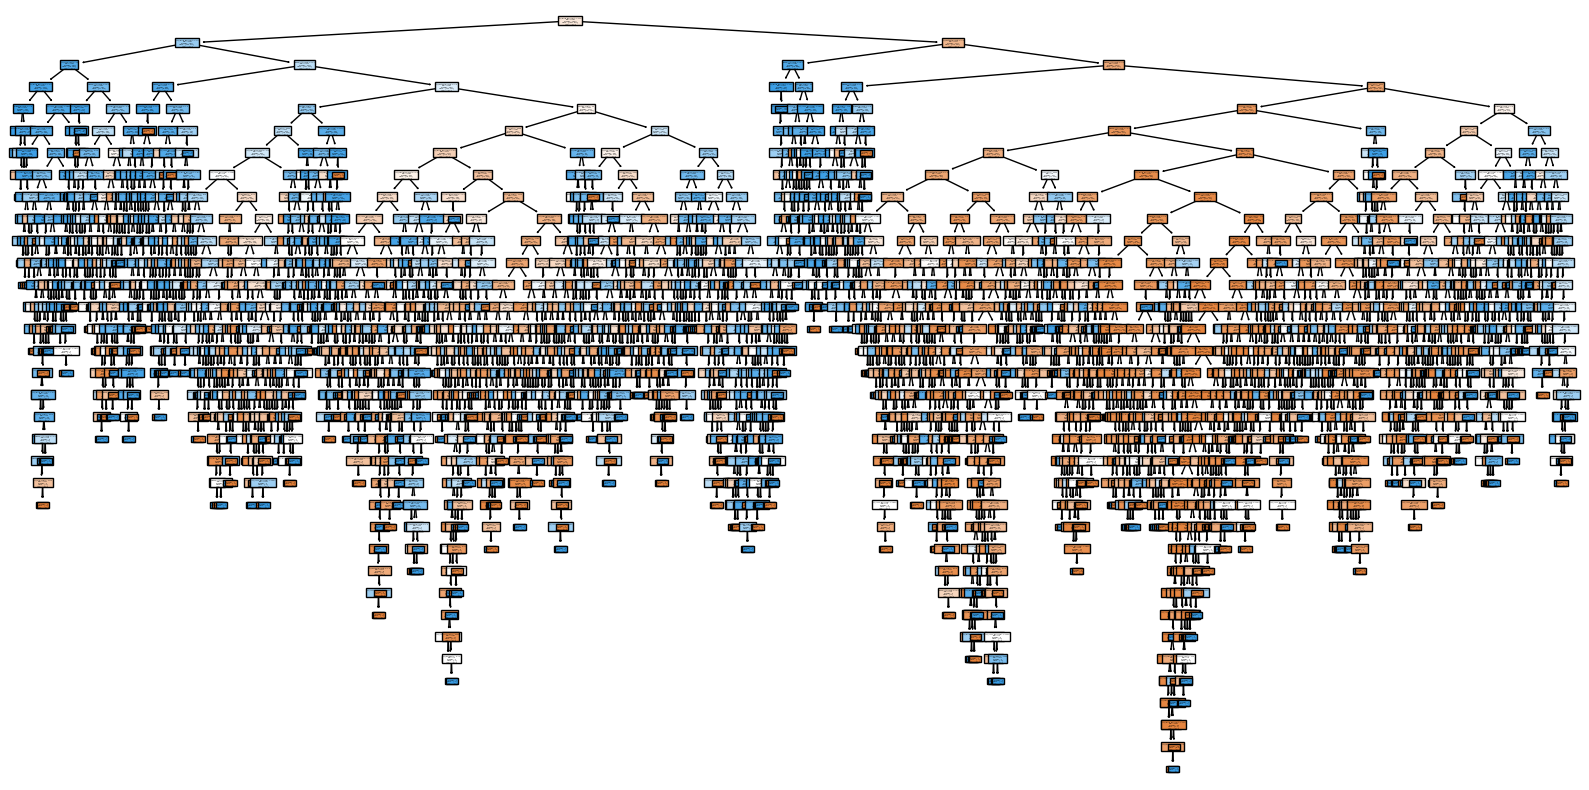

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Paths to the feature-engineered datasets
train_data_path = '/content/TrainSet_FeatureEngeneering.csv'
test_data_path = '/content/TestSet_FeatureEngeneering.csv'

# Load the data
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

# Remove rows where 'id' is string or NULL
test_data = test_data[pd.to_numeric(test_data['id'], errors='coerce').notnull()]

# Ensure labels are integers and handle missing values
train_data['label'] = train_data['label'].fillna(-1).astype(int)
test_data['label'] = test_data['label'].fillna(-1).astype(int)

y_train = train_data['label']
y_test = test_data['label']

numeric_features = ['text_word_count', 'title_word_count', 'text_unique_word_count', 'title_unique_word_count',
                    'text_punctuation_count', 'title_punctuation_count', 'text_sentiment', 'named_entity_count',
                    'exclamation_count', 'question_count', 'capital_ratio']

train_data[numeric_features] = train_data[numeric_features].astype(float)
test_data[numeric_features] = test_data[numeric_features].astype(float)

X_train_numeric = train_data[numeric_features].fillna(0)
X_test_numeric = test_data[numeric_features].fillna(0)

# Use DecisionTreeClassifier instead of RandomForestClassifier
numeric_model = DecisionTreeClassifier(random_state=42)
numeric_model.fit(X_train_numeric, y_train)

numeric_preds = numeric_model.predict(X_test_numeric)

# Print the classification report and accuracy score
print(classification_report(y_test, numeric_preds))
print("Accuracy:", accuracy_score(y_test, numeric_preds))

# Plot the decision tree
plt.figure(figsize=(20,10))
plot_tree(numeric_model, feature_names=numeric_features, class_names=['Class 0', 'Class 1'], filled=True)
plt.show()

<ipython-input-5-af2b57cb39e9>:12: DtypeWarning: Columns (0,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,

Best Hyperparameters: {'max_depth': 20, 'min_samples_split': 50}
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        11
           0       0.57      0.70      0.63      2323
           1       0.70      0.57      0.63      2854

    accuracy                           0.63      5188
   macro avg       0.42      0.42      0.42      5188
weighted avg       0.64      0.63      0.63      5188

Best Accuracy: 0.6260601387818041


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


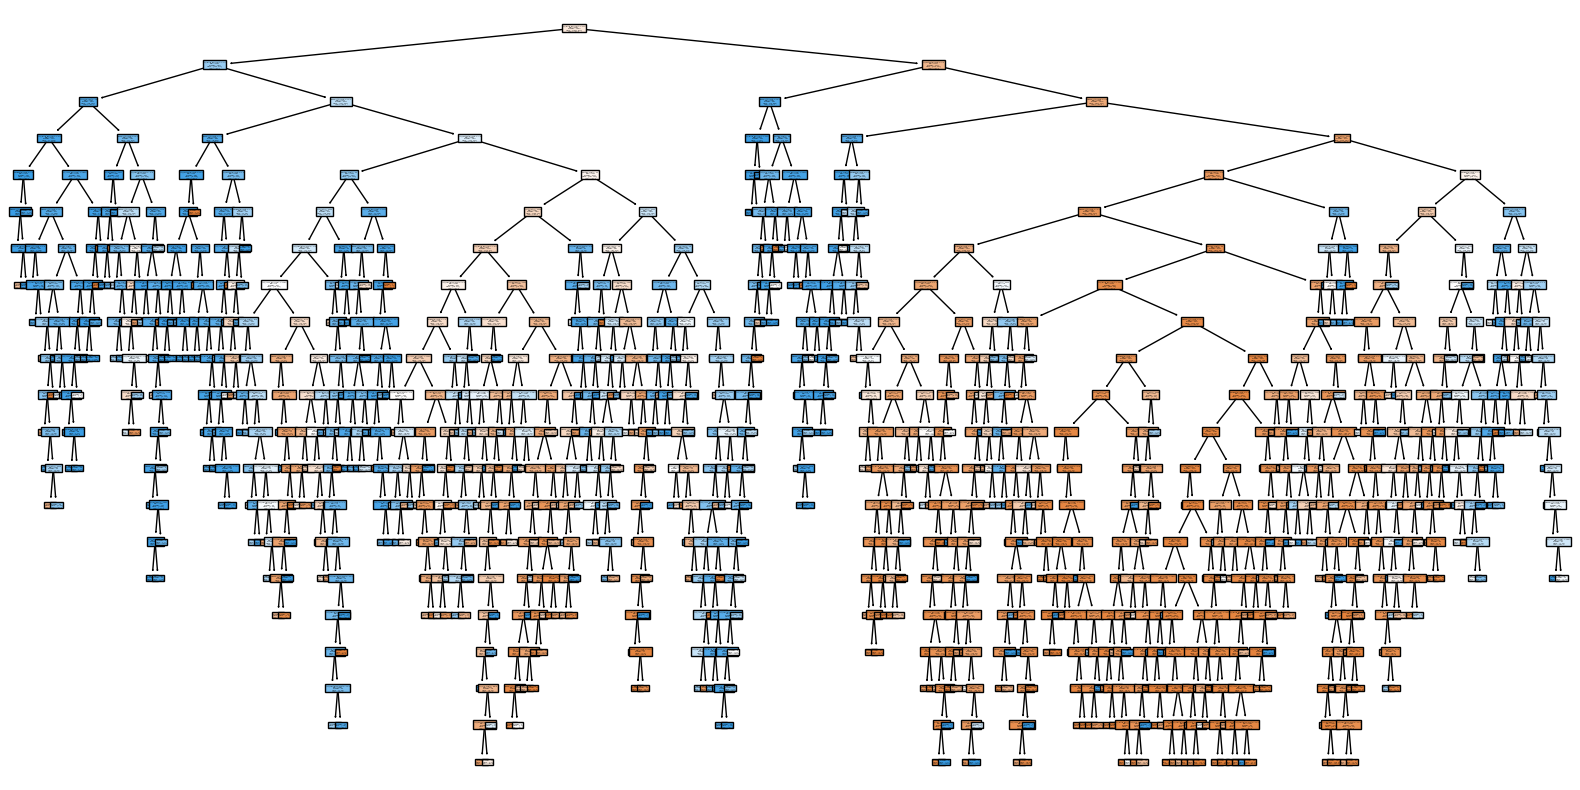

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Paths to the feature-engineered datasets
train_data_path = '/content/TrainSet_FeatureEngeneering.csv'
test_data_path = '/content/TestSet_FeatureEngeneering.csv'

# Load the data
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

# Remove rows where 'id' is string or NULL
test_data = test_data[pd.to_numeric(test_data['id'], errors='coerce').notnull()]

# Ensure labels are integers and handle missing values
train_data['label'] = train_data['label'].fillna(-1).astype(int)
test_data['label'] = test_data['label'].fillna(-1).astype(int)

y_train = train_data['label']
y_test = test_data['label']

numeric_features = ['text_word_count', 'title_word_count', 'text_unique_word_count', 'title_unique_word_count',
                    'text_punctuation_count', 'title_punctuation_count', 'text_sentiment', 'named_entity_count',
                    'exclamation_count', 'question_count', 'capital_ratio']

train_data[numeric_features] = train_data[numeric_features].astype(float)
test_data[numeric_features] = test_data[numeric_features].astype(float)

X_train_numeric = train_data[numeric_features].fillna(0)
X_test_numeric = test_data[numeric_features].fillna(0)

# Define different hyperparameters for Decision Tree
hyperparameters = [
    {'max_depth': 5, 'min_samples_split': 20},
    {'max_depth': 10, 'min_samples_split':100 },
    {'max_depth': 10, 'min_samples_split': 200},
    {'max_depth': 20, 'min_samples_split': 50},
    {'max_depth': 20, 'min_samples_split': 20}
]

best_accuracy = 0
best_model = None
best_params = None

for params in hyperparameters:
    model = DecisionTreeClassifier(random_state=42, **params)
    model.fit(X_train_numeric, y_train)
    preds = model.predict(X_test_numeric)
    accuracy = accuracy_score(y_test, preds)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_params = params

# Print the best classification report and accuracy score
best_preds = best_model.predict(X_test_numeric)
print(f"Best Hyperparameters: {best_params}")
print(classification_report(y_test, best_preds))
print("Best Accuracy:", best_accuracy)

# Plot the best decision tree
plt.figure(figsize=(20,10))
plot_tree(best_model, feature_names=numeric_features, class_names=['Class 0', 'Class 1'], filled=True)
plt.show()


<ipython-input-1-81a9881c56eb>:12: DtypeWarning: Columns (0,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,

Best Hyperparameters: {'max_depth': None, 'min_samples_split': 50}
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        11
           0       0.57      0.70      0.63      2323
           1       0.70      0.57      0.63      2854

    accuracy                           0.63      5188
   macro avg       0.42      0.42      0.42      5188
weighted avg       0.64      0.63      0.63      5188

Best Accuracy: 0.6272166538164996


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


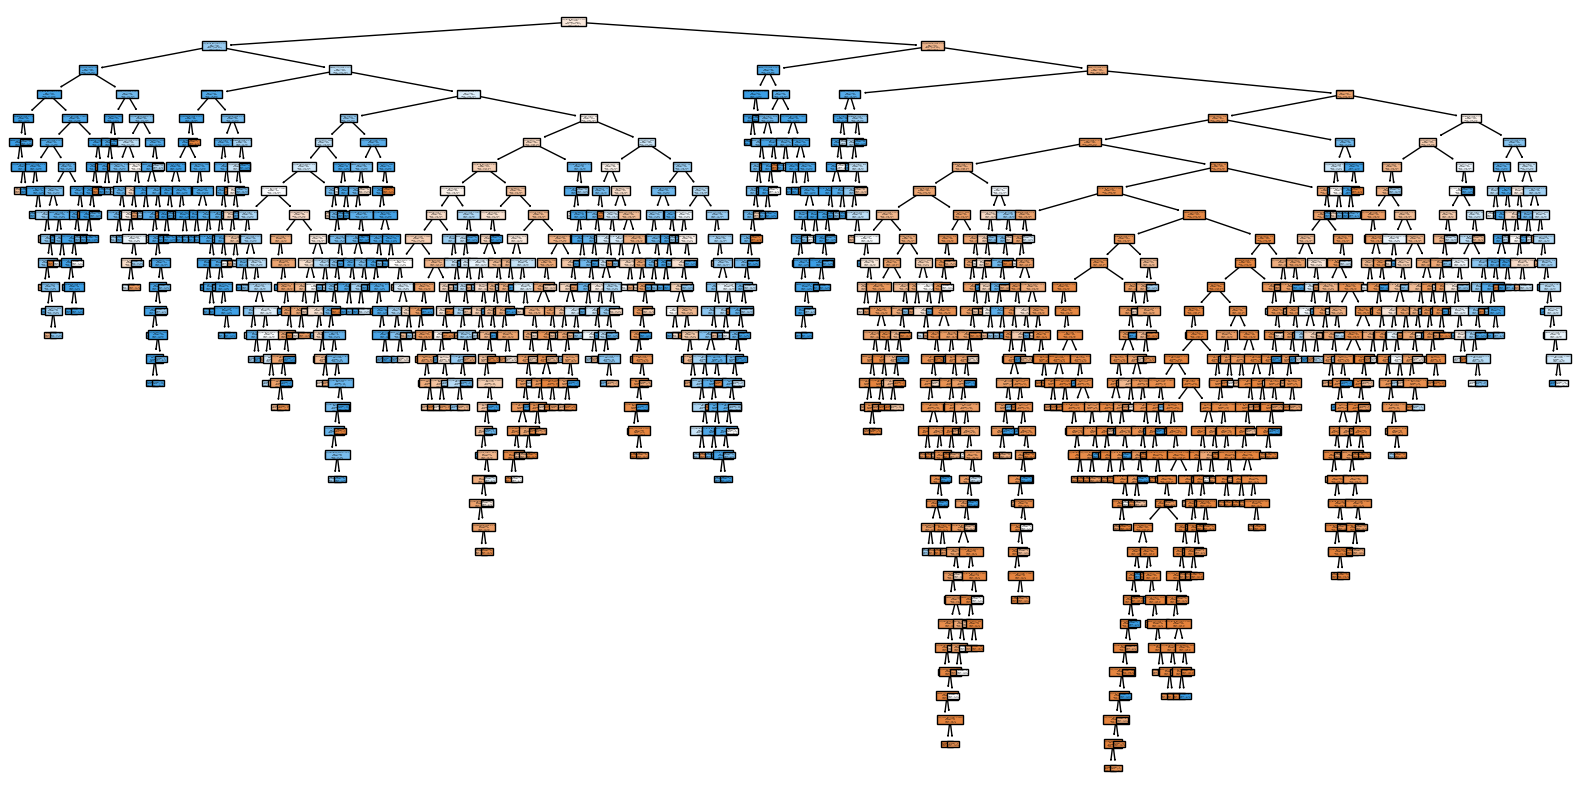

Feature Importances:
                    Feature  Importance
3   title_unique_word_count    0.285432
7        named_entity_count    0.168211
5   title_punctuation_count    0.165801
10            capital_ratio    0.113949
1          title_word_count    0.044355
4    text_punctuation_count    0.043003
2    text_unique_word_count    0.040486
6            text_sentiment    0.039656
8         exclamation_count    0.035562
9            question_count    0.034979
0           text_word_count    0.028565


In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Paths to the feature-engineered datasets
train_data_path = '/content/TrainSet_FeatureEngeneering.csv'
test_data_path = '/content/TestSet_FeatureEngeneering.csv'

# Load the data
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

# Remove rows where 'id' is string or NULL
test_data = test_data[pd.to_numeric(test_data['id'], errors='coerce').notnull()]

# Ensure labels are integers and handle missing values
train_data['label'] = train_data['label'].fillna(-1).astype(int)
test_data['label'] = test_data['label'].fillna(-1).astype(int)

y_train = train_data['label']
y_test = test_data['label']

numeric_features = ['text_word_count', 'title_word_count', 'text_unique_word_count', 'title_unique_word_count',
                    'text_punctuation_count', 'title_punctuation_count', 'text_sentiment', 'named_entity_count',
                    'exclamation_count', 'question_count', 'capital_ratio']

train_data[numeric_features] = train_data[numeric_features].astype(float)
test_data[numeric_features] = test_data[numeric_features].astype(float)

X_train_numeric = train_data[numeric_features].fillna(0)
X_test_numeric = test_data[numeric_features].fillna(0)

# Define different hyperparameters for Decision Tree
hyperparameters = [
    {'max_depth': 10, 'min_samples_split': 25},
    {'max_depth': 10, 'min_samples_split': 50},
    {'max_depth': 20, 'min_samples_split': 25},
    {'max_depth': 20, 'min_samples_split': 50},
    {'max_depth': None, 'min_samples_split': 50}
]

best_accuracy = 0
best_model = None
best_params = None

for params in hyperparameters:
    model = DecisionTreeClassifier(random_state=42, **params)
    model.fit(X_train_numeric, y_train)
    preds = model.predict(X_test_numeric)
    accuracy = accuracy_score(y_test, preds)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_params = params

# Print the best classification report and accuracy score
best_preds = best_model.predict(X_test_numeric)
print(f"Best Hyperparameters: {best_params}")
print(classification_report(y_test, best_preds))
print("Best Accuracy:", best_accuracy)

# Plot the best decision tree
plt.figure(figsize=(20,10))
plot_tree(best_model, feature_names=numeric_features, class_names=['Class 0', 'Class 1'], filled=True)
plt.show()

# Print feature importances
feature_importances = best_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': numeric_features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(importance_df)


# **Model 5** - AdaBoost with numeric features

In [ ]:
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score

# Paths to the feature-engineered datasets
train_data_path = '/content/TrainSet_FeatureEngeneering.csv'
test_data_path = '/content/TestSet_FeatureEngeneering.csv'

# Load the data
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

# Remove rows where 'id' is string or NULL
test_data = test_data[pd.to_numeric(test_data['id'], errors='coerce').notnull()]

# Ensure labels are integers and handle missing values
train_data['label'] = train_data['label'].fillna(-1).astype(int)
test_data['label'] = test_data['label'].fillna(-1).astype(int)

y_train = train_data['label']
y_test = test_data['label']

numeric_features = ['text_word_count', 'title_word_count', 'text_unique_word_count', 'title_unique_word_count',
                    'text_punctuation_count', 'title_punctuation_count', 'text_sentiment', 'named_entity_count',
                    'exclamation_count', 'question_count', 'capital_ratio']

train_data[numeric_features] = train_data[numeric_features].astype(float)
test_data[numeric_features] = test_data[numeric_features].astype(float)

X_train_numeric = train_data[numeric_features].fillna(0)
X_test_numeric = test_data[numeric_features].fillna(0)


model = AdaBoostClassifier(random_state=42)
model.fit(X_train_numeric, y_train)
preds = model.predict(X_test_numeric)
accuracy = accuracy_score(y_test, preds)

# Print the best classification report and accuracy score
preds = model.predict(X_test_numeric)
print(classification_report(y_test, preds))
print("Accuracy:", accuracy)


<ipython-input-3-7c65acf364d5>:11: DtypeWarning: Columns (0,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        11
           0       0.58      0.77      0.66      2323
           1       0.74      0.55      0.63      2854

    accuracy                           0.65      5188
   macro avg       0.44      0.44      0.43      5188
weighted avg       0.67      0.65      0.64      5188

Accuracy: 0.6457208943716268


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Attempts to run the RoBERTa and GPT-2 models failed midway due to resource limitations.

In [ ]:
import pandas as pd
from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
import numpy as np

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = self.texts[item]
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = NewsDataset(
        texts=df.content.to_numpy(),
        labels=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4,
        collate_fn=lambda x: {
            'input_ids': torch.stack([i['input_ids'] for i in x]),
            'attention_mask': torch.stack([i['attention_mask'] for i in x]),
            'label': torch.stack([i['label'] for i in x]),
            'text': [i['text'] for i in x]
        }
    )

class NewsClassifier(nn.Module):
    def __init__(self, n_classes):
        super(NewsClassifier, self).__init__()
        self.bert = RobertaModel.from_pretrained('roberta-base')
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs[0][:, 0, :]
        output = self.drop(pooled_output)
        return self.out(output)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["label"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["label"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

def get_predictions(model, data_loader, device):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts.extend(d["text"])
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["label"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            texts.extend(d["text"])
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, real_values

# Load the data
train_data_path = '/content/train.csv'
test_data_path = '/content/test.csv'

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)
test_data = test_data.dropna(subset=['label'])

# Combine 'title' and 'text' into a single feature for train and test data
train_data['content'] = train_data['author'].fillna('') +  train_data['title'].fillna('') + ' ' + train_data['text'].fillna('')
test_data['content'] = test_data['author'].fillna('') + test_data['title'].fillna('') + ' ' + test_data['text'].fillna('')


# Define features and target for the training data
X_train = train_data['content']
y_train = train_data['label']

# Define features and target for the test data
X_test = test_data['content']
y_test = test_data['label']

# Set up RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
max_len = 160
batch_size = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_data_loader = create_data_loader(train_data, tokenizer, max_len, batch_size)
test_data_loader = create_data_loader(test_data, tokenizer, max_len, batch_size)

model = NewsClassifier(n_classes=2)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * 1
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

# Train the model
print('Training the model...')
history = {'train_acc': [], 'train_loss': []}
train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(train_data)
)

print(f'Train loss {train_loss} accuracy {train_acc}')
history['train_acc'].append(train_acc)
history['train_loss'].append(train_loss)

# Evaluate the model
print('Evaluating the model...')
test_acc, test_loss = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(test_data)
)

print(f'Test Accuracy: {test_acc}')
print(f'Test Loss: {test_loss}')

# Get predictions
texts, predictions, real_values = get_predictions(model, test_data_loader, device)
print(classification_report(real_values, predictions))
print(f"Accuracy: {accuracy_score(real_values, predictions)}")


<ipython-input-1-32d784eadc90>:164: DtypeWarning: Columns (20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,2

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training the model...


 60%|█████▉    | 1555/2600 [6:05:21<3:52:33, 13.35s/it]

In [ ]:
import pandas as pd
from transformers import GPT2Tokenizer, GPT2Model, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
import numpy as np

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = self.texts[item]
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = NewsDataset(
        texts=df.content.to_numpy(),
        labels=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4,
        collate_fn=lambda x: {
            'input_ids': torch.stack([i['input_ids'] for i in x]),
            'attention_mask': torch.stack([i['attention_mask'] for i in x]),
            'label': torch.stack([i['label'] for i in x]),
            'text': [i['text'] for i in x]
        }
    )

class NewsClassifier(nn.Module):
    def __init__(self, n_classes):
        super(NewsClassifier, self).__init__()
        self.gpt = GPT2Model.from_pretrained('gpt2')
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.gpt.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.gpt(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.last_hidden_state[:, 0, :]
        output = self.drop(pooled_output)
        return self.out(output)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["label"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["label"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

def get_predictions(model, data_loader, device):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts.extend(d["text"])
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["label"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            texts.extend(d["text"])
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, real_values

# Load the data
train_data_path = '/content/train.csv'
test_data_path = '/content/test.csv'

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)
test_data = test_data.dropna(subset=['label'])

# Combine 'title' and 'text' into a single feature for train and test data
train_data['content'] = train_data['author'].fillna('') +  train_data['title'].fillna('') + ' ' + train_data['text'].fillna('')
test_data['content'] = test_data['author'].fillna('') + test_data['title'].fillna('') + ' ' + test_data['text'].fillna('')

# Define features and target for the training data
X_train = train_data['content']
y_train = train_data['label']

# Define features and target for the test data
X_test = test_data['content']
y_test = test_data['label']

# Set up GPT tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
max_len = 160
batch_size = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_data_loader = create_data_loader(train_data, tokenizer, max_len, batch_size)
test_data_loader = create_data_loader(test_data, tokenizer, max_len, batch_size)

model = NewsClassifier(n_classes=2)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * 1
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

# Train the model
print('Training the model...')
history = {'train_acc': [], 'train_loss': []}
train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(train_data)
)

print(f'Train loss {train_loss} accuracy {train_acc}')
history['train_acc'].append(train_acc)
history['train_loss'].append(train_loss)

# Evaluate the model
print('Evaluating the model...')
test_acc, test_loss = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(test_data)
)

print(f'Test Accuracy: {test_acc}')
print(f'Test Loss: {test_loss}')

# Get predictions
texts, predictions, real_values = get_predictions(model, test_data_loader, device)
print(classification_report(real_values, predictions))
print(f"Accuracy: {accuracy_score(real_values, predictions)}")


<ipython-input-1-9ed586c89fc7>:163: DtypeWarning: Columns (20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,2

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training the model...


 55%|█████▌    | 1440/2600 [6:33:02<5:10:50, 16.08s/it]